In [1]:
"""
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/my-files/projects/yem
"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n%cd /content/drive/MyDrive/my-files/projects/yem\n"

In [1]:
##############
## INITIATE ##
##############

## Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import yaml

## Import modules
from f_YEM_V1_14_2025_10_10 import pdf
from f_YEM_V1_14_2025_10_10 import f_normal
from f_YEM_V1_14_2025_10_10 import YellowstoneEcosystemModel
from f_YEM_V1_14_2025_10_10 import plot_model

## Set the device to MPS if available
device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
device = "cpu" # Force cpu for now
print(device)

## Figure parameters
plt.rcParams['figure.dpi'] = 100
FIGSIZE = (6,4)
custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'axes.facecolor':'whitesmoke'}
sns.set_theme(style="ticks", rc=custom_params)

## Font
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 14
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

#
###

cpu


In [2]:
####################
## INITIATE MODEL ##
####################

## Model
model = YellowstoneEcosystemModel("parameters-aposteriori-V1-14-2025-10-13.yaml")

#
###

12.73s
tensor([3.9929e+07, 9.2732e+07, 3.1893e+03, 4.4960e+03, 1.2709e+02, 4.4227e+01],
       dtype=torch.float64)


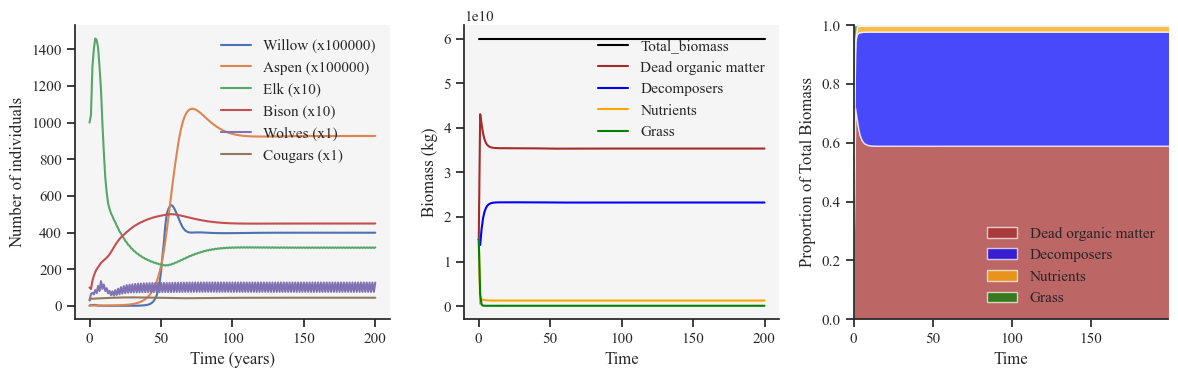

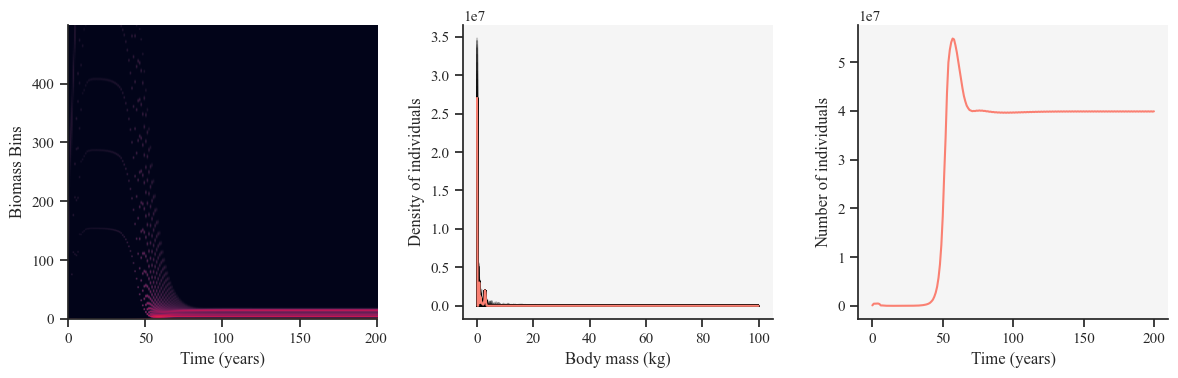

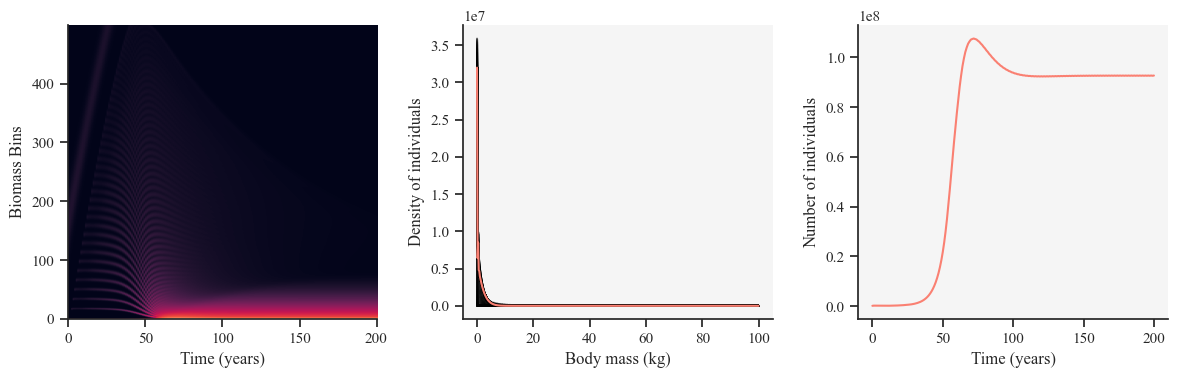

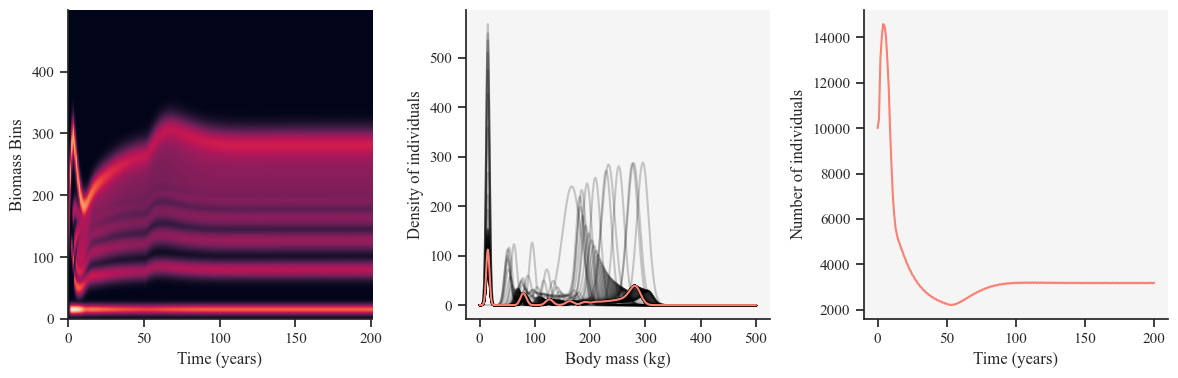

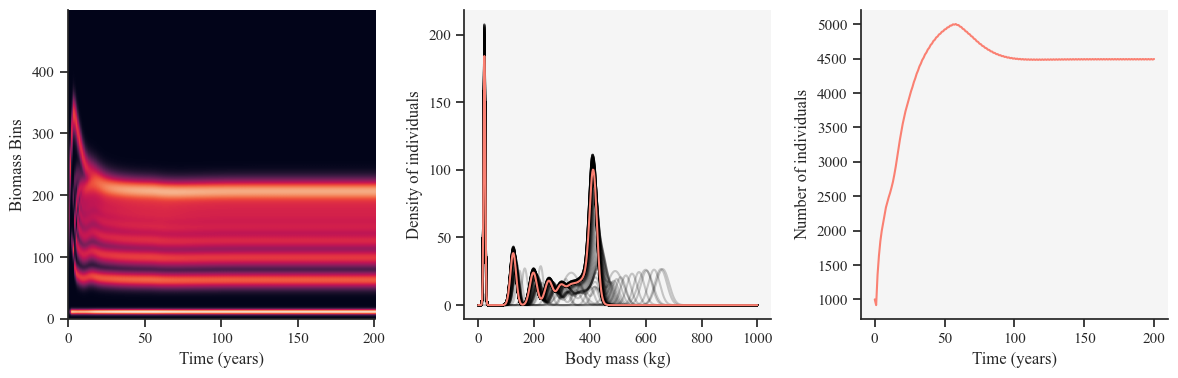

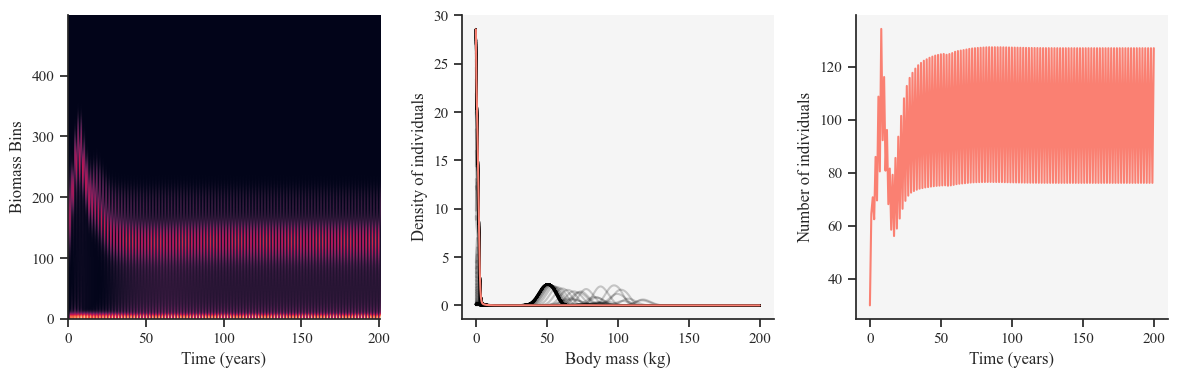

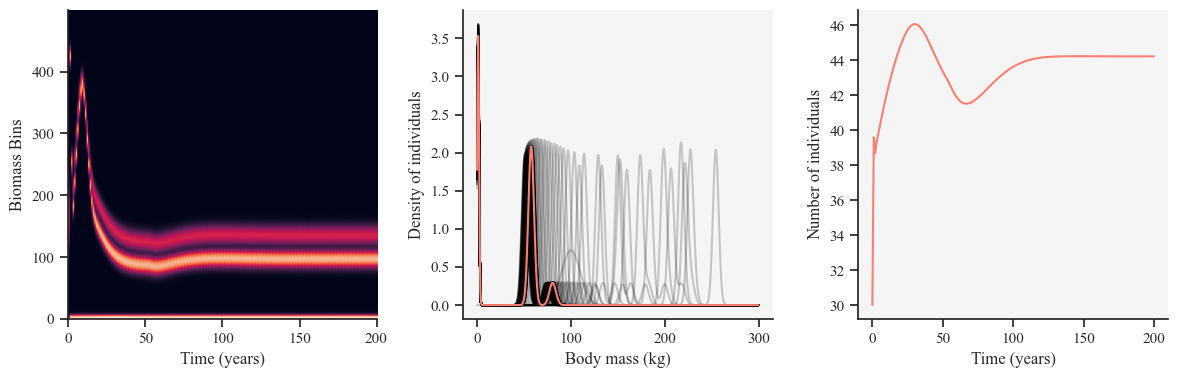

In [3]:
###############
## RUN MODEL ##
###############

## Initiate parameters
t_max_1 = 200

## Hyperparameters
INITIAL_BIOMASS = 15
ZZZ_LEN = 500
ZZMAX = [100, 100, 500, 1000, 200, 300]

## Period 1
t0 = time.time()
predictions_1 = model.simulate(t_max=t_max_1,
                             Dt = torch.tensor(INITIAL_BIOMASS*1e9, dtype=torch.float64),
                             Bt = torch.tensor(INITIAL_BIOMASS*1e9, dtype=torch.float64),
                             Pt = torch.tensor(INITIAL_BIOMASS*1e9, dtype=torch.float64),
                             Gt = torch.tensor(INITIAL_BIOMASS*1e9, dtype=torch.float64),
                             NNt = torch.tensor([1*100000, 1*100000, 1*10000, 1*1000, 1*30, 1*30], dtype=torch.float64),
                             zzmax = torch.tensor(ZZMAX, dtype=torch.float64),
                             zzz_len = ZZZ_LEN
                            )
zzz, tt, DDt, BBt, PPt, GGt, NNNt, NNNNzt, ttotal_biomass = predictions_1
tf = time.time()
print(f"{tf-t0:.2f}s")

## Equlibrium densities
print(NNNt[-1])

## Visualise
plot_model(predictions_1)

#
###

In [4]:
####################################
## FORMAT PREDICTIONS FOR FIGURES ##
####################################

## Format output
zzz, tt, DDt, BBt, PPt, GGt, NNNt, NNNNzt, ttotal_biomass = predictions_1
NNNNzt_new = [] # (time, species, phenotype) --> (species, time, phenotype)
for i in range(6):
    NNNzt_new = []
    for NNNzt in NNNNzt:
        NNNzt_new += [NNNzt[i].clone()]
    NNNNzt_new += [torch.stack(NNNzt_new)]
NNNNzt = torch.stack(NNNNzt_new)

## Calculate proportions
total_biomass = DDt.clone().detach() + BBt.clone().detach() + PPt.clone().detach() + GGt.clone().detach()
D_prop = DDt.clone().detach() / total_biomass
B_prop = BBt.clone().detach() / total_biomass
P_prop = PPt.clone().detach() / total_biomass
G_prop = GGt.clone().detach() / total_biomass

## Convert tensors to numpy for plotting
proportions = torch.stack([D_prop, B_prop, P_prop, G_prop], dim=0).numpy()

#
###

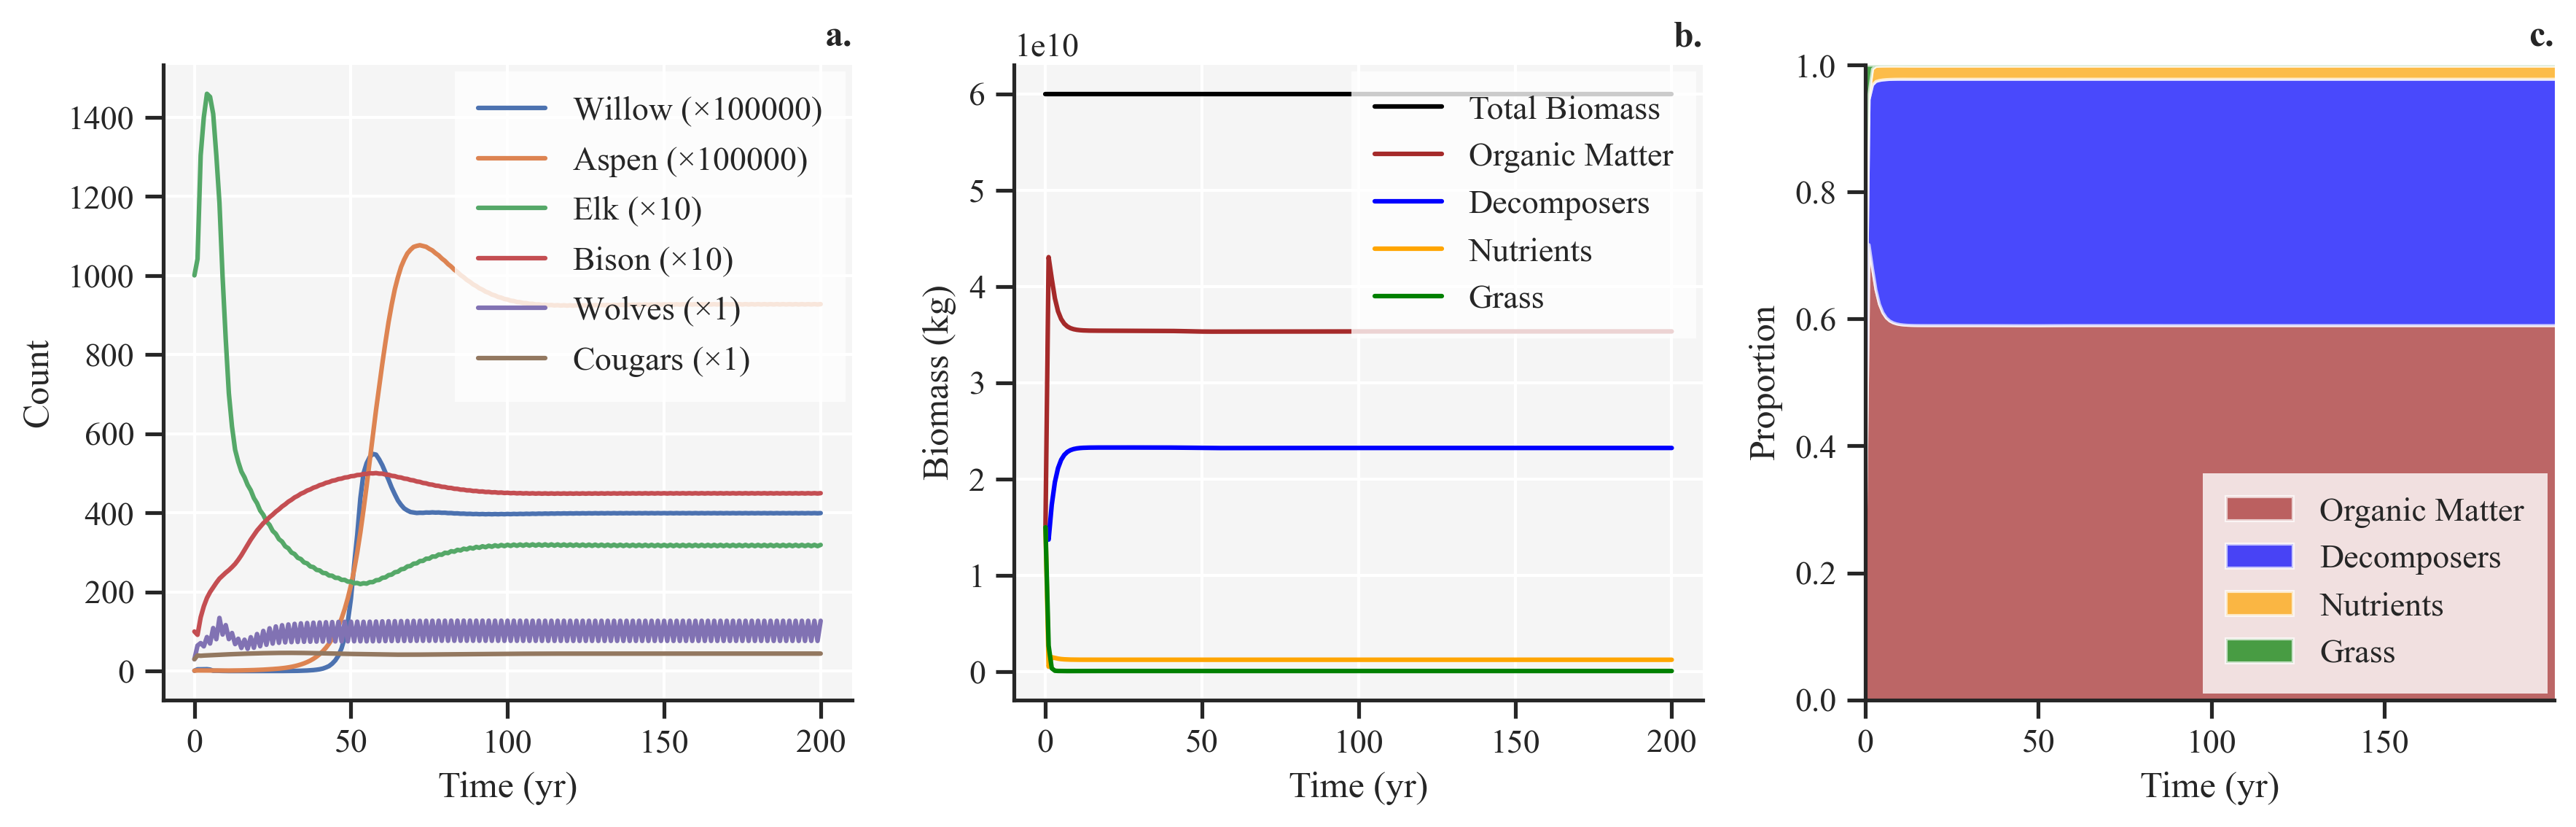

/var/folders/tb/4hh90ttd1nl4xf1zbfyq_n8w0000gp/T/ipykernel_46049/11577887.py:107: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


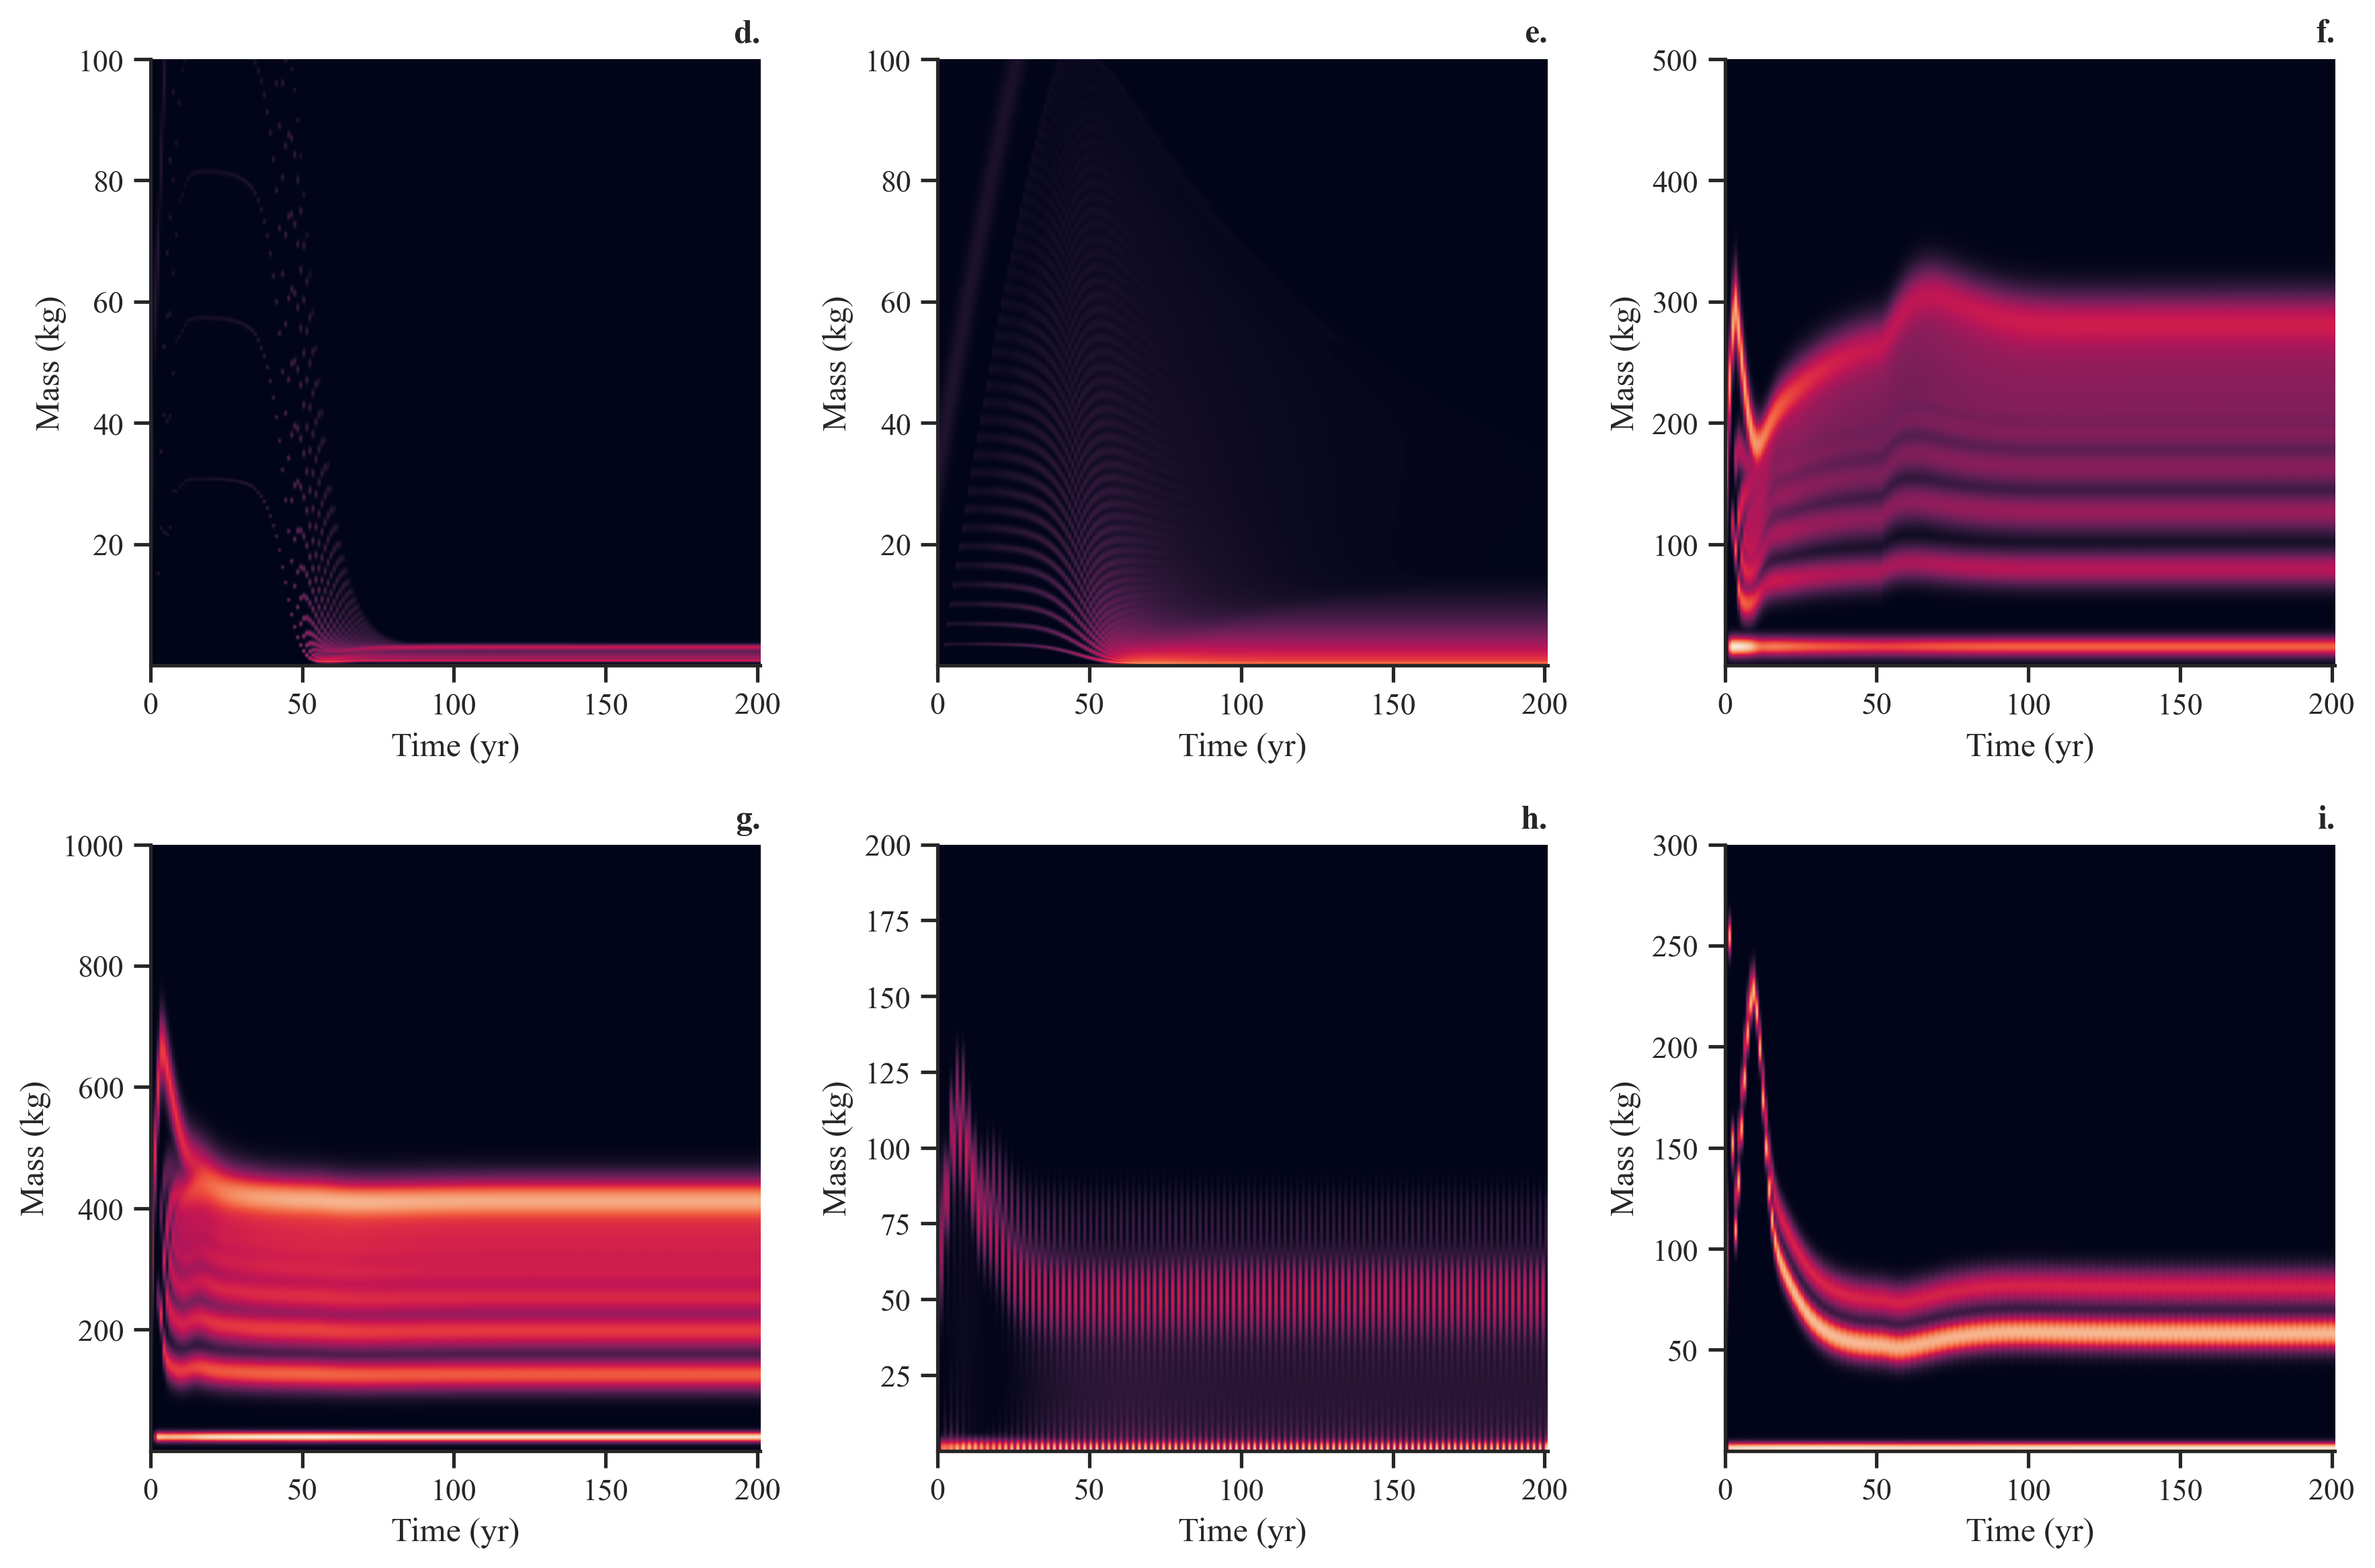

In [5]:
##############
## FIGURE 1 ##
##############

## FIGURE 1
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(12, 4))

scales = [100000, 100000, 10, 10, 1, 1]
labels = [f"Willow ($\\times{scales[0]}$)",
          f"Aspen ($\\times{scales[1]}$)",
          f"Elk ($\\times{scales[2]}$)",
          f"Bison ($\\times{scales[3]}$)",
          f"Wolves ($\\times{scales[4]}$)",
          f"Cougars ($\\times{scales[5]}$)",
         ]
#
plt.subplot(1,3,1)
for i in range(6):
    plt.plot(NNNNzt[i,:].sum(1) / scales[i], label=labels[i])
#
plt.xlabel('Time (yr)')
plt.ylabel('Count')
#
leg = plt.legend(loc='upper right')    
frame = leg.get_frame()
frame.set_boxstyle('square')
frame.set_facecolor('white')
frame.set_edgecolor('none')
#
plt.grid(color='white')
plt.title('a.', loc='right', fontweight='bold')

color_vector = {
  'Total Biomass': 'black',
  'Organic Matter': 'brown',
  'Decomposers': 'blue',
  'Nutrients': 'orange',
  'Grass': 'green'
}
#
plt.subplot(1,3,2)
#
plt.plot(tt, ttotal_biomass, label='Total Biomass', color=color_vector['Total Biomass'])
plt.plot(tt, DDt, label='Organic Matter', color=color_vector['Organic Matter'])
plt.plot(tt, BBt, label='Decomposers', color=color_vector['Decomposers'])
plt.plot(tt, PPt, label='Nutrients', color=color_vector['Nutrients'])
plt.plot(tt, GGt, label='Grass', color=color_vector['Grass'])
#
plt.xlabel('Time (yr)')
plt.ylabel('Biomass (kg)')
# plt.ylim(0, 1e11)
#
leg = plt.legend(loc='upper right', ncol=1)
frame = leg.get_frame()
frame.set_boxstyle('square')
frame.set_facecolor('white')
frame.set_edgecolor('none')
#
plt.grid(color='white')
plt.title('b.', loc='right', fontweight='bold')

## Stacked area plot
plt.subplot(1,3,3)
#
labels = ['Organic Matter', 'Decomposers', 'Nutrients', 'Grass']
colors = [color_vector[label] for label in labels]  # Extract colors for each label
#
plt.stackplot(tt, proportions, labels=labels, colors=colors, alpha=0.7)
#
plt.xlim(0, np.max(tt)-1)
plt.ylim(0, 1)
# 
plt.xlabel('Time (yr)')
plt.ylabel('Proportion')
#
leg = plt.legend(loc='lower right', ncol=1)
frame = leg.get_frame()
frame.set_boxstyle('square')
frame.set_facecolor('white')
frame.set_edgecolor('none')
#
plt.title('c.', loc='right', fontweight='bold')

## End figure
plt.tight_layout()
plt.show()
plt.rcParams['figure.dpi'] = 100

##
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(12, 4*2))
#
exponents = [.25, 0.25, .25, .25, .25, .25]
ttitles = ['d.', 'e.', 'f.', 'g.', 'h.', 'i.']
#
k = 0
for i in range(6):
    #
    zz = zzz[i]
    plt.subplot(2, 3, k+1)
    plt.imshow(NNNNzt[i].T**exponents[i], origin='lower', aspect='auto', extent=[0, NNNNzt[i].shape[0], zzz[i].min(), zzz[i].max()])    
    plt.xlabel('Time (yr)')
    plt.ylabel('Mass (kg)')
    plt.title(ttitles[k], loc='right', fontweight='bold')
    #
    plt.tight_layout()
    k += 1
#
plt.show()
plt.rcParams['figure.dpi'] = 100

#
###